# Stock Price Analysis (2012–2019)

## Data Preprocessing, EDA & Feature Engineering

This notebook includes clean preprocessing, EDA, feature engineering, and review-ready insights. Timeline strictly follows raw data (2012–2019).

In [128]:
!pip install yfinance

In [129]:
!pip install pandas_datareader

## Import Libraries & Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr
# Load data CLEANLY
df = pd.read_csv("AAPL.csv")

# CHECK column names
print(df.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


## Date Cleaning and Sorting

In [2]:
# FORCE datetime conversion
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where Date failed to parse
df = df.dropna(subset=['Date'])

# Set Date as index
df = df.set_index('Date')

# SORT (important)
df = df.sort_index()

# VERIFY
print(type(df.index))
print(df.index.min(), df.index.max())


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
2012-01-02 00:00:00 2019-12-12 00:00:00


 ## Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796 entries, 2012-01-02 to 2019-12-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       796 non-null    float64
 1   High       796 non-null    float64
 2   Low        796 non-null    float64
 3   Close      796 non-null    float64
 4   Adj Close  796 non-null    float64
 5   Volume     796 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.5 KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,796.000000,796.000000,796.000000,796.000000,796.000000,7.960000e+02
mean,126.132924,127.283482,124.969162,126.216739,118.962840,5.787877e+07
std,50.191742,50.699702,49.827337,50.390790,52.212275,4.151107e+07
min,57.527142,58.895714,57.317142,58.459999,50.765709,1.136200e+07
25%,85.676429,86.193214,84.875359,85.611784,75.543108,2.798072e+07
50%,112.025002,112.915001,110.239998,111.979999,104.287880,4.388335e+07
75%,166.102501,168.652496,164.545002,166.732495,161.366161,7.273160e+07
max,270.000000,272.559998,268.500000,271.459991,269.600067,2.943031e+08


In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Feature Engineering

In [6]:
df['MA_21'] = df['Close'].rolling(21).mean()
df['MA_50'] = df['Close'].rolling(50).mean()

## Trend Analysis

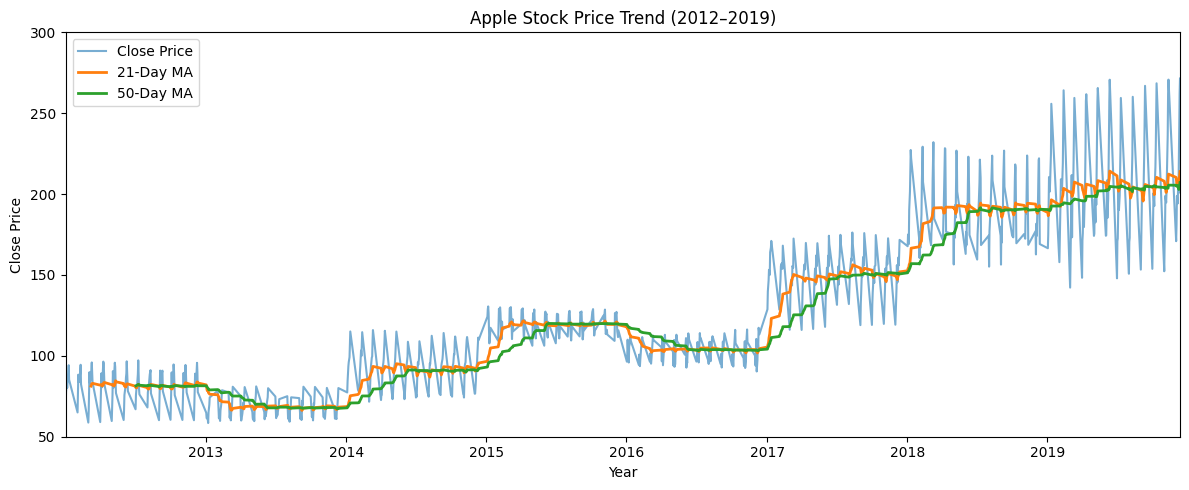

In [7]:
plt.figure(figsize=(12,5))

plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
plt.plot(df.index, df['MA_21'], label='21-Day MA', linewidth=2)
plt.plot(df.index, df['MA_50'], label='50-Day MA', linewidth=2)

plt.title('Apple Stock Price Trend (2012–2019)')
plt.xlabel('Year')
plt.ylabel('Close Price')

plt.legend()
plt.grid(False)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

## lock axes to data range (x)
plt.xlim(df.index.min(), df.index.max())

# force Y-axis to end at 300
plt.ylim(df['Close'].min() * 0.95, 300)

# clean y-axis ticks up to 300
plt.yticks(range(50, 301, 50))

plt.tight_layout()
plt.show()


## Volatility Measuring

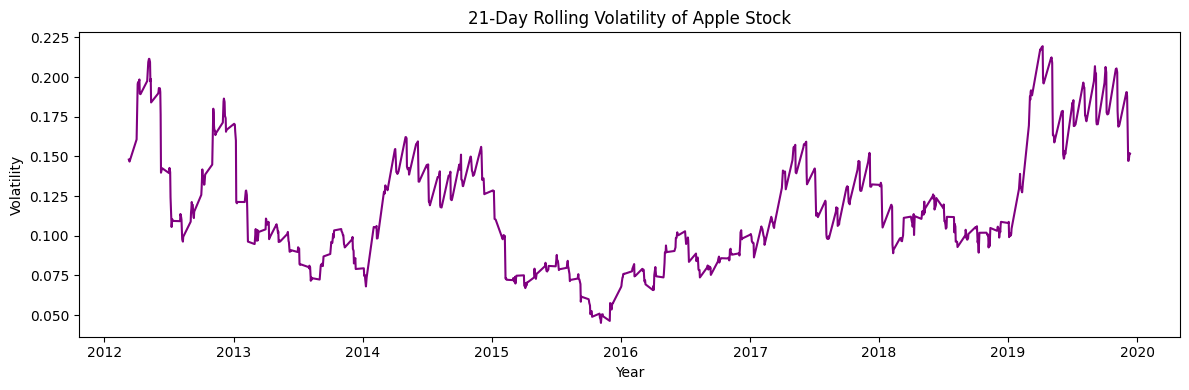

In [8]:
# Daily returns
df['Daily_Return'] = df['Close'].pct_change()

# 21-day rolling volatility (approx 1 trading month)
df['Volatility_21'] = df['Daily_Return'].rolling(window=21).std()

# Plot volatility
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Volatility_21'], color='purple')
plt.title('21-Day Rolling Volatility of Apple Stock')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()


## S&P 500 Trend

[*********************100%***********************]  1 of 1 completed


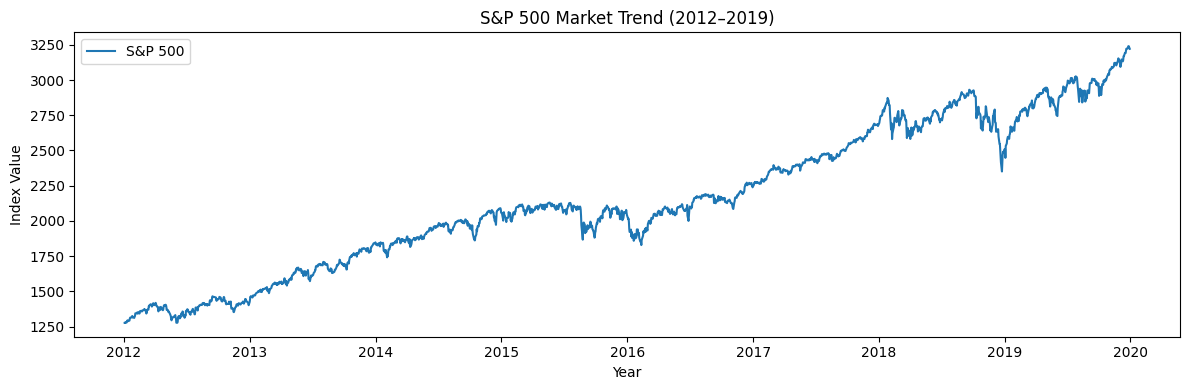

In [9]:
sp500 = yf.download("^GSPC", start="2012-01-01", end="2019-12-31", auto_adjust=False)
sp500.columns = sp500.columns.get_level_values(0)

plt.figure(figsize=(12,4))
plt.plot(sp500.index, sp500['Close'], label='S&P 500')
plt.title('S&P 500 Market Trend (2012–2019)')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.tight_layout()
plt.show()


## Inflation Rates

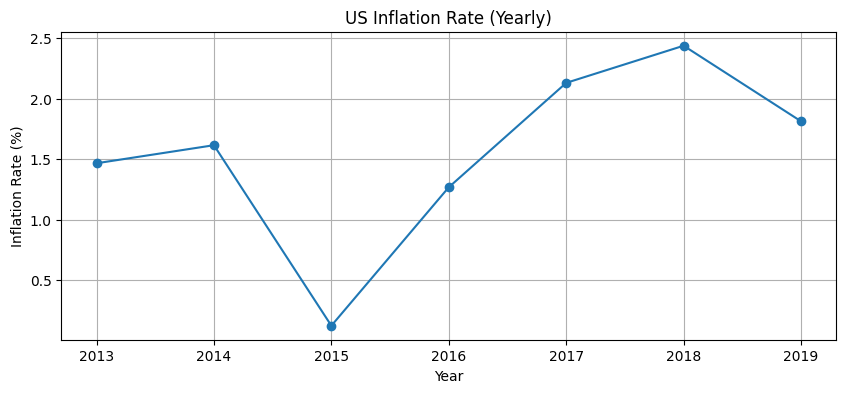

In [10]:
# Fetch CPI
cpi = pdr.DataReader('CPIAUCSL', 'fred', start='2012-01-01', end='2019-12-31')

# Resample to yearly inflation rate
inflation = cpi.resample('YE').mean().pct_change() * 100
inflation.rename(columns={'CPIAUCSL': 'Inflation_Rate'}, inplace=True)

# Plot inflation
plt.figure(figsize=(10,4))
plt.plot(inflation.index.year, inflation['Inflation_Rate'], marker='o')
plt.title('US Inflation Rate (Yearly)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()


## Earning Reports

In [11]:
# Example Apple earnings months (approx – quarterly)
earnings_months = [1, 4, 7, 10]

# Create earnings
df['Earnings_Month'] = df.index.month.isin(earnings_months).astype(int)

# Compare volatility
df.groupby('Earnings_Month')['Daily_Return'].std()


Earnings_Month
0    0.122539
1    0.120038
Name: Daily_Return, dtype: float64

## Correlation Analysis

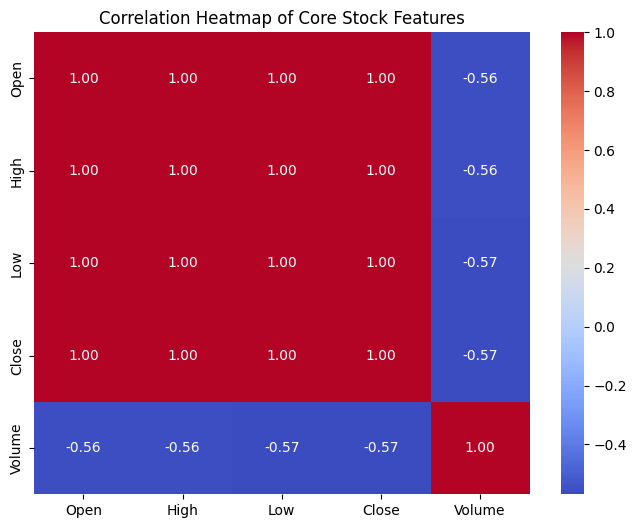

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Core Stock Features')
plt.show()

## Seasonality Analysis

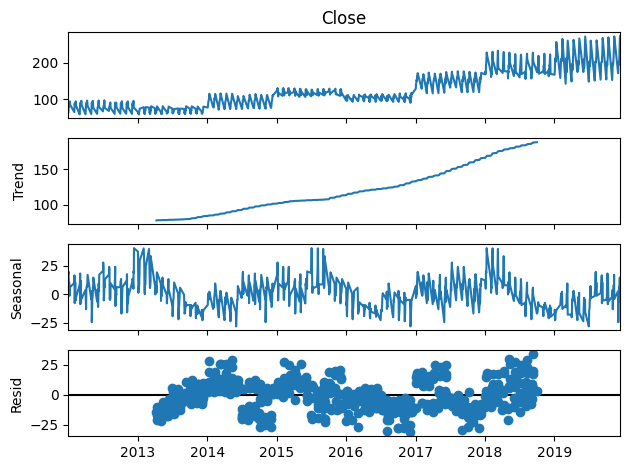

In [13]:
decomp = seasonal_decompose(df['Close'], model='additive', period=252)
decomp.plot()
plt.show()

## Seasonality Analysis

In [14]:
result = adfuller(df['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.1008462923063064
p-value: 0.9661188269058008


## Box Plot

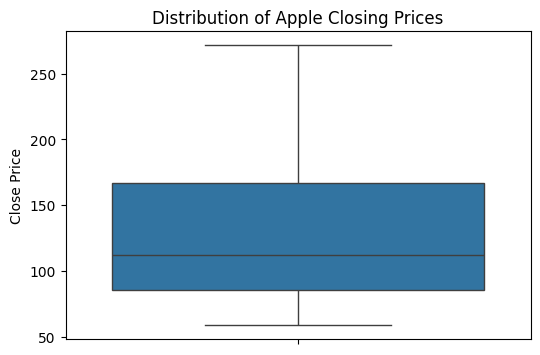

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['Close'])
plt.title('Distribution of Apple Closing Prices')
plt.ylabel('Close Price')
plt.show()

### Train–Test Split

In [16]:

ts = df["Close"]
split = int(len(ts) * 0.8)
train, test = ts[:split], ts[split:]


## ARIMA MODEL

### Stationarity Check (ADF Test)

In [17]:
def adf_test(series, title=""):
    series = series.dropna()
    result = adfuller(series, autolag="AIC")

    print(f"ADF Test: {title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("✅ Stationary\n")
    else:
        print("❌ Non-stationary\n")

adf_test(train, "Original Series")


ADF Test: Original Series
ADF Statistic: 0.2770
p-value: 0.9763
❌ Non-stationary



### Make Series Stationary (Differencing)

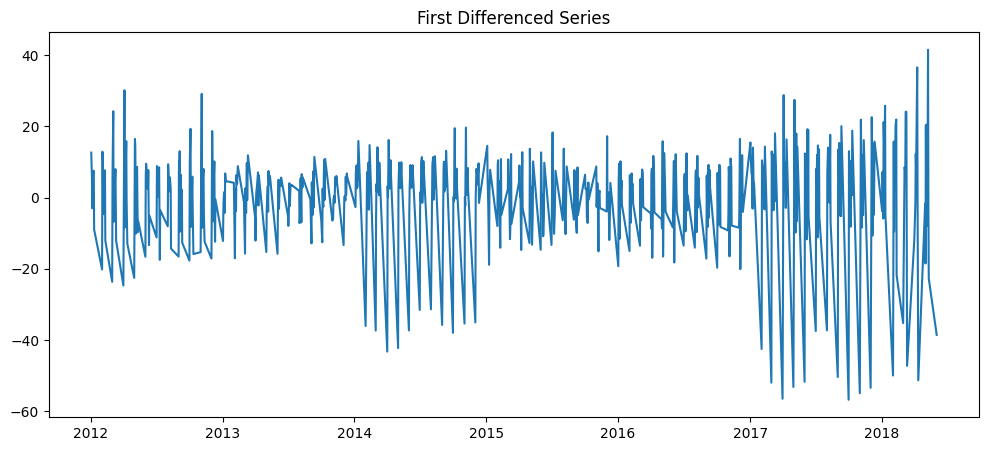

ADF Test: First Difference
ADF Statistic: -12.4718
p-value: 0.0000
✅ Stationary



In [18]:
train_diff = train.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(train_diff)
plt.title("First Differenced Series")
plt.show()

adf_test(train_diff, "First Difference")


### ACF & PACF Plots

<Figure size 1200x500 with 0 Axes>

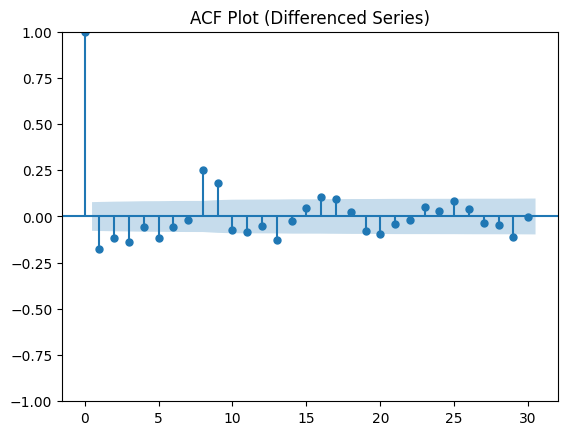

<Figure size 1200x500 with 0 Axes>

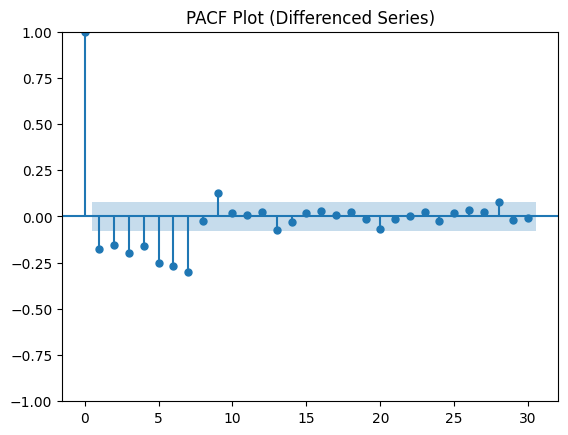

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(train_diff, lags=30)
plt.title("ACF Plot (Differenced Series)")
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(train_diff, lags=30, method="ywm")
plt.title("PACF Plot (Differenced Series)")
plt.show()


### Auto-Select d

In [21]:
def find_d(series, max_d=2):
    for d in range(max_d + 1):
        if d == 0:
            test_series = series
        else:
            test_series = series.diff(d)

        test_series = test_series.dropna()
        if len(test_series) < 10:
            continue

        p_value = adfuller(test_series, autolag="AIC")[1]
        if p_value < 0.05:
            return d

    return max_d

d = find_d(train)
print("Selected d:", d)


Selected d: 1


In [22]:
import numpy as np

### Auto-Select ARIMA (p, d, q) Using AIC

In [23]:
def auto_arima(train, d, p_max=5, q_max=5):
    best_aic = np.inf
    best_order = None

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except:
                continue

    return best_order

best_arima_order = auto_arima(train, d)
print("Best ARIMA order:", best_arima_order)


Best ARIMA order: None


In [24]:
import warnings
warnings.filterwarnings('ignore')

### Fit ARIMA Model

In [27]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_order = auto_arima(train, d)
print("Best ARIMA order:", best_order)

arima_model = ARIMA(train, order=best_order)
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(len(test))


Best ARIMA order: (5, 1, 3)


In [28]:
arima_model = ARIMA(train, order=best_order)
arima_result = arima_model.fit()

print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  636
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2414.939
Date:                Tue, 06 Jan 2026   AIC                           4847.878
Time:                        10:14:03   BIC                           4887.961
Sample:                             0   HQIC                          4863.442
                                - 636                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0725      0.108      9.936      0.000       0.861       1.284
ar.L2         -0.9502      0.108     -8.838      0.000      -1.161      -0.739
ar.L3          0.0526      0.092      0.571      0.5

### ARIMA Forecast

In [29]:
arima_forecast = arima_result.forecast(steps=len(test))


In [30]:
arima_forecast

636    169.769329
637    180.388642
638    190.577018
639    198.465487
640    207.124956
          ...    
791    191.685200
792    191.703136
793    191.717582
794    191.720853
795    191.712077
Name: predicted_mean, Length: 160, dtype: float64

## SARIMA MODEL

### Auto-Select SARIMA Seasonal Parameters

In [31]:
def auto_sarima(train, order, m=5):
    best_aic = np.inf
    best_seasonal = None

    for P in range(3):
        for Q in range(3):
            try:
                model = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=(P, 0, Q, m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                result = model.fit(disp=False)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_seasonal = (P, 0, Q, m)
            except:
                continue

    return best_seasonal


In [32]:
best_seasonal_order = auto_sarima(train, best_arima_order)
print("Best SARIMA seasonal order:", best_seasonal_order)


Best SARIMA seasonal order: (1, 0, 2, 5)


### Fit SARIMA Model

In [33]:
sarima_model = SARIMAX(
    train,
    order=best_arima_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


                                  SARIMAX Results                                   
Dep. Variable:                        Close   No. Observations:                  636
Model:             SARIMAX(1, 0, [1, 2], 5)   Log Likelihood               -2584.261
Date:                      Tue, 06 Jan 2026   AIC                           5176.522
Time:                              10:14:26   BIC                           5194.273
Sample:                                   0   HQIC                          5183.420
                                      - 636                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5        1.0082      0.002    424.037      0.000       1.004       1.013
ma.S.L5       -0.7652      0.037    -20.631      0.000      -0.838      -0.692
ma.S

In [34]:
sarima_forecast = sarima_result.forecast(steps=len(test))


### Evaluation Metrics

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"MAPE: {mape:.2f}%\n")

evaluate(test, arima_forecast, "ARIMA")
evaluate(test, sarima_forecast, "SARIMA")


ARIMA Performance:
RMSE: 29.91
MAE:  22.21
MAPE: nan%

SARIMA Performance:
RMSE: 39.47
MAE:  32.36
MAPE: nan%



### Final Forecast Comparison Plot

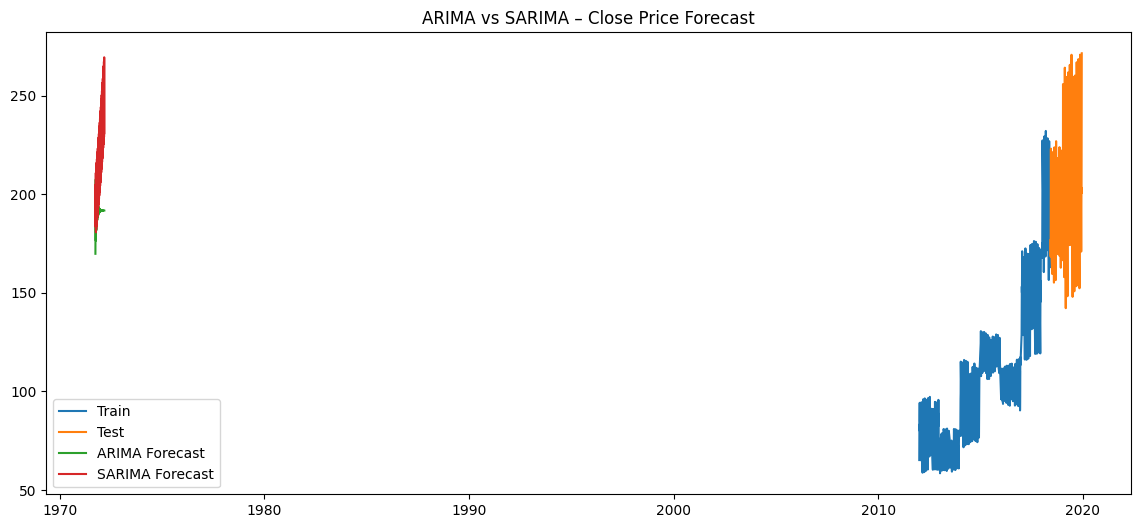

In [36]:
plt.figure(figsize=(14,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.plot(sarima_forecast, label="SARIMA Forecast")
plt.legend()
plt.title("ARIMA vs SARIMA – Close Price Forecast")
plt.show()


**LSTM**

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [38]:
df1=df.reset_index()['Close']

In [39]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.03150234]
 [0.09071092]
 [0.11596916]
 [0.10179074]
 [0.1325218 ]
 [0.16778672]
 [0.12563382]
 [0.03078471]
 [0.09118713]
 [0.14044939]
 [0.1185513 ]
 [0.12293763]
 [0.13317908]
 [0.16907445]
 [0.11239438]
 [0.00134809]
 [0.03384306]
 [0.14761905]
 [0.11576124]
 [0.12755868]
 [0.13848426]
 [0.17587525]
 [0.11869218]
 [0.00283033]
 [0.14425889]
 [0.1046479 ]
 [0.10400402]
 [0.1782361 ]
 [0.17275654]
 [0.1117572 ]
 [0.00590879]
 [0.08312544]
 [0.15054325]
 [0.10302484]
 [0.13462107]
 [0.17505704]
 [0.16322603]
 [0.11763918]
 [0.08690142]
 [0.00883971]
 [0.03672031]
 [0.08118042]
 [0.1088129 ]
 [0.13189805]
 [0.14307848]
 [0.179108  ]
 [0.11645204]
 [0.09256874]
 [0.03997989]
 [0.08146883]
 [0.10748492]
 [0.10898727]
 [0.14197856]
 [0.18190476]
 [0.09978539]
 [0.0831858 ]
 [0.04524482]
 [0.08904761]
 [0.10661302]
 [0.1147552 ]
 [0.14127433]
 [0.15355468]
 [0.08620389]
 [0.00839035]
 [0.0563045 ]
 [0.09118044]
 [0.15225353]
 [0.10728373]
 [0.13727029]
 [0.14185782]
 [0.15199868]
 [0.09

In [40]:
## splitting dataset into train and test split

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(517, 279)

In [41]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ## i=0, 0,1,2,3-----99 i.e 100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0]) # appending 100th value when i=0
	return np.array(dataX), np.array(dataY)


In [42]:
# reshape into X=t,t+1,t+2,t+3 till 100 and Y=t+101
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)

(416, 100)
(416,)


(None, None)

In [43]:
print(X_test.shape), print(ytest.shape)

(178, 100)
(178,)


(None, None)

In [42]:
!pip install tensorflow

In [44]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [46]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - loss: 0.0233 - val_loss: 0.0196
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0083 - val_loss: 0.1132
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0068 - val_loss: 0.0466
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0051 - val_loss: 0.0255
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0038 - val_loss: 0.0233
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0035 - val_loss: 0.0239
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0036 - val_loss: 0.0185
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0034 - val_loss: 0.0191
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0033 - val_loss: 0.0177
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0033 - val_loss: 0.0177
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0033 - val_loss: 0.0177
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.

In [47]:
## Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

print('Prediction using training data : \n',train_predict)
print('Prediction using testing data : \n',test_predict)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
Prediction using training data : 
 [[0.11702948]
 [0.1062066 ]
 [0.09321291]
 [0.07891172]
 [0.06532343]
 [0.05419061]
 [0.04682014]
 [0.04398003]
 [0.0429065 ]
 [0.04244388]
 [0.04143753]
 [0.04037634]
 [0.04005197]
 [0.04196681]
 [0.04619114]
 [0.04991916]
 [0.05225284]
 [0.05296809]
 [0.05159378]
 [0.0497096 ]
 [0.04803368]
 [0.04862341]
 [0.05117803]
 [0.05336459]
 [0.053701  ]
 [0.05201303]
 [0.04906136]
 [0.04648482]
 [0.044692  ]
 [0.04469424]
 [0.0474587 ]
 [0.05060736]
 [0.05237949]
 [0.05202829]
 [0.05005496]
 [0.04644645]
 [0.0426385 ]
 [0.0399281 ]
 [0.03940933]
 [0.04212483]
 [0.04560993]
 [0.04787769]
 [0.04892391]
 [0.04845517]
 [0.04716422]
 [0.04620733]
 [0.04653933]
 [0.04919149]
 [0.05339793]
 [0.0572404 ]
 [0.0590285 ]
 [0.05892368]
 [0.05696458]
 [0.05403   ]
 [0.05122424]
 [0.04960667]
 [0.049767  ]
 [0.05061207]
 [0.05062613]
 [0.04918462]
 [0.04707751]
 [0.04382781]
 [0.04044877]
 [0.

In [48]:
## Transform back data to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [49]:
## Calculate MSE performance metrics

math.sqrt(mean_squared_error(y_train,train_predict))

99.52028278183023

In [50]:
## Test Data MSE

math.sqrt(mean_squared_error(ytest,test_predict))

159.67330737595006

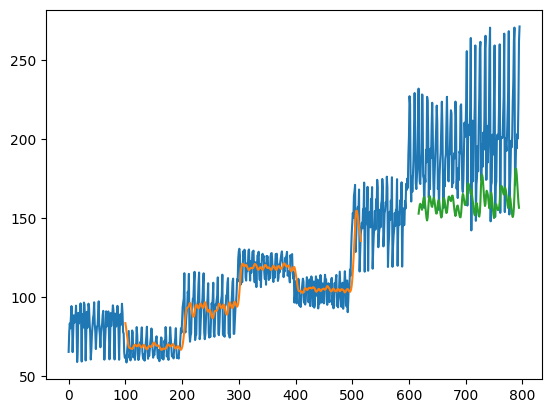

In [51]:
## Plotting train and test data division visually

import matplotlib.pyplot as plt

# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**XGBOOST**

In [52]:
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr

In [53]:
X = df.drop(columns=["Close"])
y = df["Close"]

In [54]:
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [55]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)

In [56]:
from scipy.stats import randint, uniform

param_dist = {
    "n_estimators": randint(300, 800),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 0.3),
    "min_child_weight": randint(1, 8)
}

In [57]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

In [59]:
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002787FBB14F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002787D9FE210>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002787FB9C140>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [61]:
best_model = search.best_estimator_
best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.706712405710114), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.2929844867497959), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.05110370133182313), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=684, n_jobs=None,
             num_parallel_tree=None, ...)

In [62]:
y_pred = best_model.predict(X_test)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", search.best_params_)
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

Best Parameters: {'colsample_bytree': np.float64(0.706712405710114), 'gamma': np.float64(0.2929844867497959), 'learning_rate': np.float64(0.05110370133182313), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 684, 'subsample': np.float64(0.695824756266789)}
RMSE: 11.80
MAE:  6.01
R²:   0.8385


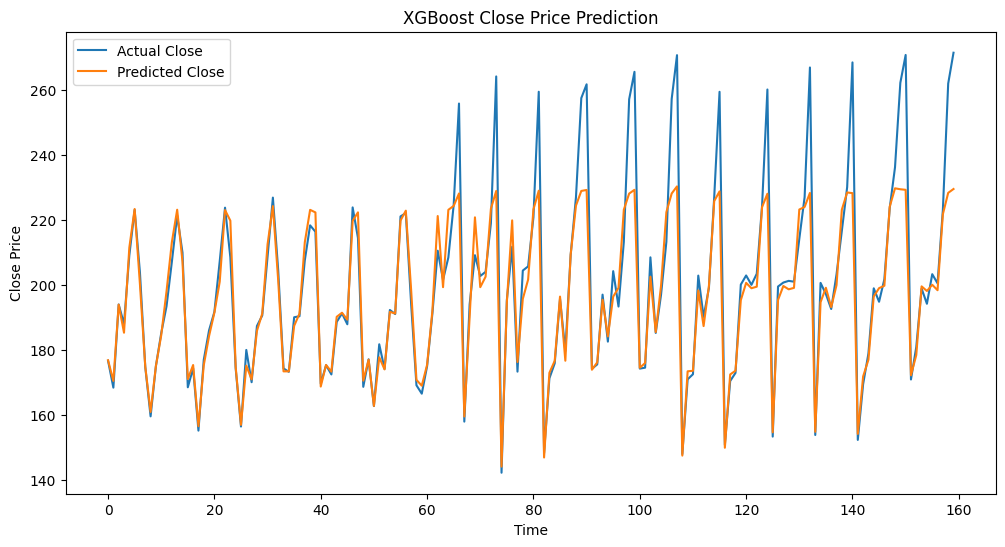

In [64]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Close")
plt.plot(y_pred, label="Predicted Close")
plt.title("XGBoost Close Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

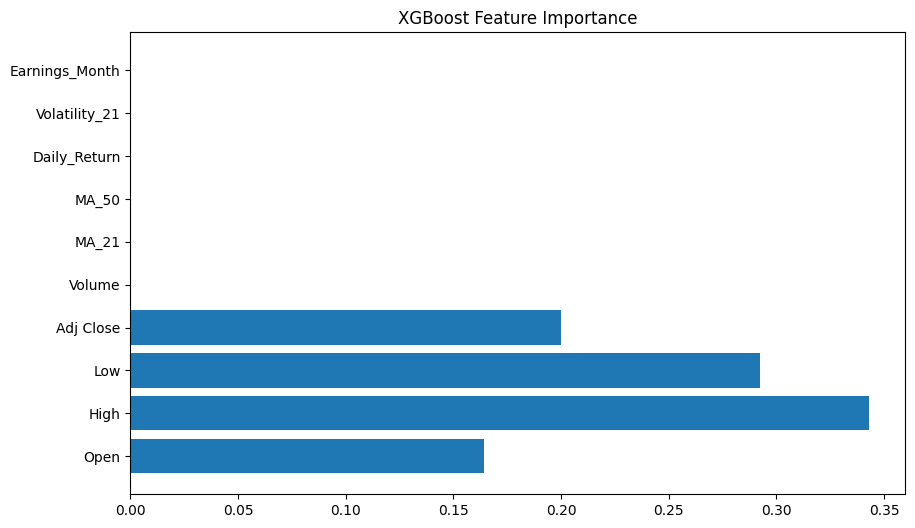

In [65]:
plt.figure(figsize=(10,6))
plt.barh(X.columns, best_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

**Model Deployment**

In [65]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [66]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.offsets import BDay

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
st.set_page_config(page_title="Stock Price Forecaster", layout="wide")
st.title("Stock Price Prediction for Next N Business Days")

2026-01-06 10:20:20.634 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:20.638 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:21.151 
  command:

    streamlit run C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-01-06 10:20:21.159 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:21.160 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [69]:
# Sidebar
# -------------------------
st.sidebar.header("Settings")
uploaded_file = st.sidebar.file_uploader("Upload stock CSV", type=["csv"])
forecast_days = st.sidebar.slider("Forecast Days (Business Days)", 1, 90, 30)


2026-01-06 10:20:23.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.830 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.837 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:23.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [70]:
# Main
# -------------------------
if uploaded_file:
    df = pd.read_csv(uploaded_file)

    if {"Date", "Close"} - set(df.columns):
        st.error("CSV must contain 'Date' and 'Close' columns")
        st.stop()

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df.dropna(subset=["Date"], inplace=True)
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)

    if len(df) < 120:
        st.error("Minimum 120 rows required")
        st.stop()

In [71]:
# Feature Engineering
# -------------------------
df["MA_21"] = df["Close"].rolling(21).mean()
df["MA_50"] = df["Close"].rolling(50).mean()
df["Daily_Return"] = df["Close"].pct_change()
df["Volatility_21"] = df["Daily_Return"].rolling(21).std()
df["Earnings_Month"] = df.index.month.isin([1, 4, 7, 10]).astype(int)

df.dropna(inplace=True)

In [72]:
 FEATURES = [
        "MA_21",
        "MA_50",
        "Daily_Return",
        "Volatility_21",
        "Earnings_Month"
    ]

In [73]:
 X = df[FEATURES]
y = df["Close"]


In [74]:
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [75]:
 # Train Model
    # -------------------------
with st.spinner("Training model..."):
      model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=400,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method="hist"
        )
model.fit(X_train, y_train)

st.success("Model trained successfully")

2026-01-06 10:20:36.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.893 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:36.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:37.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [76]:
 # Evaluation
    # -------------------------
preds = pd.Series(model.predict(X_test), index=X_test.index)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
dir_acc = (
np.sign(y_test.diff().dropna())
== np.sign(preds.diff().dropna())
).mean() * 100

col1, col2, col3 = st.columns(3)
col1.metric("RMSE", f"{rmse:.2f}")
col2.metric("MAE", f"{mae:.2f}")
col3.metric("Direction Accuracy", f"{dir_acc:.2f}%")

2026-01-06 10:20:40.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.362 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.367 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:40.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [77]:
 # Forecasting (FIXED)
    # -------------------------
st.subheader(f"{forecast_days}-Day Business Forecast")

forecast_dates = pd.date_range(
df.index[-1] + BDay(1),
periods=forecast_days,
freq=BDay()
    )

close_history = list(df["Close"][-50:])
forecast_prices = []

for date in forecast_dates:
     ma21 = np.mean(close_history[-21:])
     ma50 = np.mean(close_history[-50:])

returns = np.diff(close_history[-21:]) / close_history[-21:-1]
daily_ret = returns[-1] if len(returns) else 0
vol21 = np.std(returns) if len(returns) else 0


2026-01-06 10:20:42.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:42.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:42.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [78]:
 # 🔒 FEATURE SCHEMA LOCK (FIX)
feature_row = pd.DataFrame(
            [[
                ma21,
                ma50,
                daily_ret,
                vol21,
                int(date.month in [1, 4, 7, 10])
            ]],
            columns=FEATURES
        )

next_price = model.predict(feature_row)[0]
forecast_prices.append(next_price)
close_history.append(next_price)

forecast_df = pd.DataFrame(
{"Forecast_Close": forecast_prices},
index=forecast_dates
    )

In [79]:
 # Plot
    # -------------------------
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
forecast_df.index,
forecast_df["Forecast_Close"],
marker="o",
label="Forecast"
    )
ax.set_title("Forecasted Closing Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.legend()
st.pyplot(fig)
plt.close(fig)

2026-01-06 10:20:46.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:47.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:47.150 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:47.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [80]:
# Table & Final Price
    # -------------------------
st.subheader("Forecast Table")
st.dataframe(forecast_df)

st.success(
f"Final predicted price after {forecast_days} business days: "
f"{forecast_df.iloc[-1,0]:.2f}"
    )

2026-01-06 10:20:47.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:47.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:47.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:48.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:48.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:48.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:48.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 10:20:48.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()